In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install pybullet gym==0.21.0
!apt update
!apt install xvfb
!pip install pybullet gym-notebook-wrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.42.0
    Uninstalling wheel-0.42.0:
      Successfully uninstalled wheel-0.42.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616799 sha256=a5ed3e24424d4aadf79874d04d5e9e4f8c73cffe26d500635d3065f3299d188a
  Stored in directory: /root/.cache/pip/wheels/81/aa/90/b67df76370d3916a2189b662cf48da38ce41a4e7e58b6abff5
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease

In [ ]:
import time
import os
import gc
import random

import numpy as np
import matplotlib.pyplot as plt

import gym
import pybullet_envs  # PyBulletの環境をgymに登録
import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_

import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import gnwrapper # 環境可視化用のwrapper
from typing import Tuple, List, Optional

# matplotlibをColab上で描画するためのコマンド
%matplotlib inline
import matplotlib.pyplot as plt

# Gymの警告を一部無視する
gym.logger.set_level(40)

In [ ]:
def make_env(seed=1234):
    env = gym.make('HalfCheetahBulletEnv-v0')  # 環境を読み込む.

    # シード固定
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    return env

In [ ]:
def set_seed(seed: int) -> None:
    """
    Pytorch, NumPyのシード値を固定します
    Parameters
    ----------
    seed : int
        シード値．
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def torch_log(x):
    return torch.log(x + 1e-6)

def calculate_log_pi(log_stds, noises, actions):
    """
    確率論的な行動の確率密度の対数を返す

    Parameters
    ----------
    log_stds : torch.Tensor ( batch_size, action_shape[0] )
        ガウス分布の標準偏差の対数
    noises : torch.Tensor ( batch_size, action_shape[0] )
        Remarametrization trickにおける標準ガウス分布からのノイズ
    actions : torch.Tensor ( batch_size, action_shape[0] )

    Returns
    ----------
    log_pis : torch.Tensor ( batch_size, 1 )
        行動の確率密度の対数
    """
    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|s))を計算する
    gaussian_log_probs = \
        (-0.5 * noises.pow(2) - log_stds).sum(dim=-1, keepdim=True) - 0.5 * math.log(2 * math.pi) * log_stds.size(-1)

    # tanhによる確率密度の変化を修正
    log_pis = gaussian_log_probs - torch_log(1 - actions.pow(2)).sum(dim=-1, keepdim=True)

    return log_pis


def reparameterize(means, log_stds):
    """
    Reparameterization trickを用いて，確率論的な行動とその確率密度を返す

    Parameters
    ----------
    means : torch.Tensor ( batch_size, action_shape[0] )
        ガウス分布の平均
    log_stds : torch.Tensor ( batch_size, action_shape[0] )
        ガウス分布の標準偏差の対数

    Returns
    ----------
    actions : torch.Tensor ( batch_size, action_shape[0] )
        確率的な行動
    log_pis : torch.Tensor ( batch_size, 1 )
        行動の確率密度の対数
    """
    # 標準偏差に戻す
    stds = log_stds.exp()

    # 標準ガウス分布から\epsilonをサンプリング
    noises = torch.randn_like(means)

    # Reparameterization trickを用いてガウス分布からのサンプルを計算
    us = means + noises * stds

    # tanhを適用し，確率論的な行動を計算
    actions = torch.tanh(us)

    # actionsの確率密度の対数を計算
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [ ]:
class PPOActor(nn.Module):
    def __init__(self, state_shape, action_shape, hidden=64):
        """
        状態を受け取り, ガウス分布の平均を出力するネットワーク

        Parameters
        ----------
        state_shape : Tuple[int]
            状態次元数．e.g. ( 26, )
        action_shape : Tuple[int]
            行動次元数．e.g. ( 6, )
        hidden : int
            隠れ層のユニット数
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        """
        決定的な行動を返す．

        Parameters
        ----------
        states : torch.Tensor ( batch_size, state_shape[0] )

        Returns
        ----------
        actions : torch.Tensor ( batch_size, action_shape[0] )
        """
        return torch.tanh(self.net(states))

    def sample(self, states):
        """
        確率的な行動とその確率密度の対数を返す．

        Parameters
        ----------
        states : torch.Tensor ( batch_size, state_shape[0] )

        Returns
        ----------
        actions : torch.Tensor ( batch_size, action_shape[0] )
        log_pis : torch.Tensor ( batch_size, 1 )
        """
        means = self.net(states)

        return reparameterize(means, self.log_stds)

    @staticmethod
    def atanh(x):
        """ tanh の逆関数 """
        return 0.5 * (torch_log(1 + x) - torch_log(1 - x))

    def evaluate_log_pi(self, states, actions):
        """
        平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，
        行動(actions)の確率密度の対数を計算．
        """
        means = self.net(states)

        noises = (self.atanh(actions) - means) / (self.log_stds.exp() + 1e-8)

        return calculate_log_pi(self.log_stds, noises, actions)

In [ ]:
class PPOCritic(nn.Module):
    def __init__(self, state_shape, hidden=64) -> None:
        """
        状態を受け取り，状態価値を出力するネットワーク．

        Parameters
        ----------
        state_shape : Tuple[int]
            状態次元数．e.g. ( 26, )
        hidden : int
            隠れ層のユニット数
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, states) -> torch.Tensor:
        """
        Parameters
        ----------
        states : torch.Tensor ( batch_size, state_shape[0] )

        Returns
        ----------
        values : torch.Tensot ( batch_size, 1 )
        """
        return self.net(states)

In [ ]:
def calculate_advantage(values, rewards, dones, next_values, gamma=0.995, lambd=0.997):
    """
    GAEを用いて，状態価値のターゲットとアドバンテージを計算する．

    Parameters
    ----------
    values : torch.Tensor ( T, 1 )
        現在の状態価値
    rewards : torch.Tensor ( T, 1 )
        即時報酬
    dones : torch.Tensor ( T, 1 )
        エピソードが終わっているかを示すbool列
    next_values : torch.Tensor ( T, 1 )
        次ステップの状態価値

    Returns
    ----------
    targets : torch.Tensor ( T, 1 )
        状態価値のターゲット
    advantages : torch.Tensor ( T, 1 )
        アドバンテージの推定値
    """
    # TD誤差を計算
    deltas = rewards + gamma * next_values * (1 - dones) - values

    # GAEを初期化．
    advantages = torch.empty_like(rewards)

    # 終端ステップを計算
    advantages[-1] = deltas[-1]

    # 終端ステップの1つ前から，順番にGAEを計算
    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    # 状態価値のターゲットをλ-収益として計算．
    targets = advantages + values

    # GAEを標準化
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages

In [ ]:
class RolloutBuffer:
    def __init__(self, buffer_size, state_shape, action_shape, device=torch.device('cuda')):
        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

        # 次にデータを挿入するインデックス．
        self._p = 0
        # バッファのサイズ．
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))
        # リングバッファにする
        self._p = (self._p + 1) % self.buffer_size

    def get(self):
        return self.states, self.actions, self.rewards, self.dones, self.log_pis, self.next_states

    def clear(self):
        self.states = torch.empty_like(self.states)
        self.actions = torch.empty_like(self.actions)
        self.rewards = torch.empty_like(self.rewards)
        self.dones = torch.empty_like(self.dones)
        self.log_pis = torch.empty_like(self.log_pis)
        self.next_states = torch.empty_like(self.next_states)
        self._p = 0

In [ ]:
# モデルの定義
class PPO:
    def __init__(
        self, state_shape, action_shape, device=torch.device('cuda'),
        batch_size=64, gamma=0.995, lr_actor=3e-4, lr_critic=3e-4, buffer_size=2048,
        horizon=2048, num_updates=10, num_steps=None, clip_eps=0.2, lambd=0.97,
        coef_ent=0.0, max_grad_norm=0.5, max_action=1.
    ):
        """
        Parameters
        ----------
        state_shape : Tuple[int]
            状態次元数．e.g. ( 26, )
        action_shape : Tuple[int]
            行動次元数．e.g. ( 6, )
        gamma : float
            割引率
        buffer_size : int
            ロールアウトバッファのサイズ
        horizon : int
            ホライズン．T
        num_updates : int
            1ステップ行動のたびに何回パラメータを更新するか
        num_steps : Optional[int]
            総ステップ数．学習率をアニーリングしたいときに渡す
        clip_eps : float
            方策の更新比のクリッピングのためのハイパーパラメータ
        lambd : float
            GAEのNステップ収益の重みを決めるハイパーパラメータ
        coef_ent : float
            方策エントロピー項の重み（学習の安定化）
        max_grad_norm : float
            Actor, Criticネットワークの勾配を制約する（学習の安定化）
        max_action : float
            行動範囲が[-1, 1]でない環境で使用
        """

        # データ保存用のバッファ
        self.buffer = RolloutBuffer(
            buffer_size=buffer_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device
        )

        # Actor-Criticのネットワークを構築
        self.actor = PPOActor(
            state_shape=state_shape,
            action_shape=action_shape,
        ).to(device)
        self.critic = PPOCritic(
            state_shape=state_shape,
        ).to(device)

        # オプティマイザ
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        if num_steps is not None:
            # 学習安定のため学習率のアニーリング
            self.sched_actor = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optim_actor,
                T_max=num_steps//horizon,
                eta_min=lr_actor*0.01
            )
            self.sched_critic = torch.optim.lr_scheduler.CosineAnnealingLR(
                self.optim_critic,
                T_max=num_steps//horizon,
                eta_min=lr_critic*0.01
            )

        # その他パラメータ
        self.learning_steps = 0
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.horizon = horizon
        self.buffer_size = buffer_size
        self.num_updates = num_updates
        self.num_steps = num_steps
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm
        self.max_action = max_action

    def is_update(self, steps: int) -> bool:
        """
        ロールアウト1回分のデータが溜まったら学習する．

        Parameters
        ----------
        steps : int
            現在の学習ステップ
        """
        return steps % self.horizon == 0

    @torch.no_grad()
    def explore(self, state) -> Tuple[np.ndarray, float]:
        """
        確率論的な行動と，その行動の確率密度の対数 log(pi(a|s)) を返す．

        Parameters
        ----------
        state : torch.Tensor ( state_shape[0], )

        Returns
        ----------
        action : np.ndarray ( action_shape[0], )
            確率的な行動．Actorがモデリングするガウス分布からのサンプル
        loh_pi : float
            行動に対応する確率の対数
        """
        state = torch.from_numpy(state.astype(np.float32)).to(self.device).unsqueeze(0)

        action, log_pi = self.actor.sample(state)

        return action.cpu().numpy()[0] * self.max_action, log_pi.item()

    @torch.no_grad()
    def exploit(self, state) -> np.ndarray:
        """
        決定論的な行動を返す．

        Parameters
        ----------
        state : torch.Tensor ( state_shape[0], )

        Returns
        ----------
        action : np.ndarray ( action_shape[0], )
            決定論的な行動．Actorがモデリングするガウス分布の平均
        """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)

        action = self.actor(state)

        return action.cpu().numpy()[0] * self.max_action

    @torch.no_grad()
    def get_value(self, state) -> np.ndarray:
        """
        Criticネットワークで状態価値を計算

        Parameters
        ----------
        state : np.ndarray ( state_shape[0], )

        Returns
        ----------
        value : np.ndarray ( 1, )
            状態価値の推定値
        """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)

        value = self.critic(state)

        return value.cpu().numpy()[0]

    def step(self, env, state: np.ndarray, t: int, steps: int) -> Tuple[np.ndarray, int]:
        """
        環境で1ステップ行動をとり，得た次の状態や報酬をロールアウトバッファにためる．

        Parameters
        ----------
        state : np.ndarray ( state_shape[0], )
        t: int
            エピソード内における現在のステップ数
        steps : int
            今までのトータルのステップ数（現在の学習ステップ）
        """
        t += 1

        # 現在の方策（ガウス分布）から確率論的な行動をサンプリング
        action, log_pi = self.explore(state)

        next_state, reward, done, _ = env.step(action)

        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        # ロールアウトバッファにデータを追加
        self.buffer.append(state, action, reward, done_masked, log_pi, next_state)

        # エピソードが終了した場合には，環境をリセット
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self) -> None:
        self.learning_steps += 1

        """
        ロールアウトバッファの中身をすべて取得
            states ( buffer_size, state_shape[0] )
            actions ( buffer_size, action_shape[0] )
            rewards ( buffer_size, 1 )
        """
        states, actions, rewards, dones, log_pis, next_states = self.buffer.get()

        # 状態価値の計算
        with torch.no_grad():
            values = self.critic(states)
            next_values = self.critic(next_states)

        # 状態価値からアドバンテージを推定 (GAE)
        targets, advantages = calculate_advantage(
            values, rewards, dones, next_values, self.gamma, self.lambd
        )

        # バッファ内のデータを num_updates回ずつ使って，ネットワークを更新
        for _ in range(self.num_updates):
            # インデックスをシャッフル
            indices = np.arange(self.buffer_size)
            np.random.shuffle(indices)

            # ミニバッチに分けて学習
            for start in range(0, self.buffer_size, self.batch_size):
                idxes = indices[start:start+self.batch_size]
                self.update_critic(states[idxes], targets[idxes])
                self.update_actor(states[idxes], actions[idxes], log_pis[idxes], advantages[idxes])

        if self.num_steps is not None:
            self.sched_critic.step()
            self.sched_actor.step()

        # return self.optim_actor.param_groups[0]['lr']

    def update_critic(self, states, targets) -> None:
        """
        平均二乗誤差でcriticネットワークのパラメータを更新

        Parameters
        ----------
        states : torch.Tensor ( batch_size, state_shape[0] )
        targets : torch.Tensor ( batch_size, 1 )
            状態価値のターゲット
        """
        # 状態価値とターゲット状態価値の平均二乗誤差
        loss_critic = F.mse_loss(self.critic(states), targets)

        self.optim_critic.zero_grad()
        loss_critic.backward(retain_graph=False)
        # 勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.optim_critic.step()

    def update_actor(self, states, actions, log_pis_old, advantages) -> None:
        """
        Actor（方策）ネットワークのパラメータを更新

        Parameters
        ----------
        states : torch.Tensor ( batch_size, state_shape[0] )
        actions : torch.Tensor ( batch_size, action_shape[0] )
        log_pis_old : torch.Tensor ( batch_size, 1 )
            データ収集時の方策における行動の確率の対数
        advantages : torch.Tensor ( batch_size, 1 )
            GAEで推定されたアドバンテージ
        """
        # 現在の方策における actions の確率の対数を計算する．
        log_pis = self.actor.evaluate_log_pi(states, actions)

        ratios = (log_pis - log_pis_old).exp_()

        loss_actor1 = -ratios * advantages
        loss_actor2 = -torch.clamp(
            ratios,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps
            ) * advantages

        # 局所解に陥ることを防ぐ
        mean_entropy = -log_pis.mean()

        loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        # 勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.optim_actor.step()

In [ ]:
# 平均収益を保存するための辞書．
returns = {'step': [], 'return': []}

def evaluate_policy(steps, eval_episodes=3):
    """ 複数エピソード環境を動かし，平均収益を記録する． """
    _returns = []
    for _ in range(eval_episodes):
        state = env_test.reset()
        done = False
        episode_return = 0.0

        while (not done):
            action = algo.exploit(state)
            state, reward, done, _ = env_test.step(action)
            episode_return += reward

        _returns.append(episode_return)

    mean_return = np.mean(_returns)
    returns['step'].append(steps)
    returns['return'].append(mean_return)

    print(
        f'Num steps: {steps:<6}   '
        f'Return: {mean_return:<5.1f}   '
        f'Time elapsed: {str(timedelta(seconds=int(time() - start_time)))}'
    )

In [ ]:
# モデルの学習
set_seed(1234)  # PyTorchのシード固定
env = make_env()
env_test = make_env(seed=2*31)

NUM_STEPS = 2 * 10 ** 6
EVAL_INTERVAL = 10 ** 4

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    num_steps=NUM_STEPS,
)

# 学習開始の時間
start_time = time()
# エピソードのステップ数
t = 0

# 環境を初期化
state = env.reset()


""" メインループ """
for steps in range(1, NUM_STEPS+1):
    # 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
    # アルゴリズムに渡し，状態・エピソードのステップ数を更新
    state, t = algo.step(env, state, t, steps)

    if algo.is_update(steps):
        algo.update()

    # 一定のインターバルで評価.
    if steps % EVAL_INTERVAL == 0:
        evaluate_policy(steps)

Num steps: 10000    Return: -1407.6   Time elapsed: 0:00:29
Num steps: 20000    Return: -1386.0   Time elapsed: 0:00:58
Num steps: 30000    Return: -753.2   Time elapsed: 0:01:28
Num steps: 40000    Return: -1029.8   Time elapsed: 0:01:58
Num steps: 50000    Return: -1107.5   Time elapsed: 0:02:27
Num steps: 60000    Return: 293.4   Time elapsed: 0:02:57
Num steps: 70000    Return: -1303.8   Time elapsed: 0:03:27
Num steps: 80000    Return: -756.0   Time elapsed: 0:03:57
Num steps: 90000    Return: -1148.2   Time elapsed: 0:04:24
Num steps: 100000   Return: -492.2   Time elapsed: 0:04:53
Num steps: 110000   Return: -593.1   Time elapsed: 0:05:22
Num steps: 120000   Return: 11.9    Time elapsed: 0:05:50
Num steps: 130000   Return: 73.1    Time elapsed: 0:06:20
Num steps: 140000   Return: 55.4    Time elapsed: 0:06:48
Num steps: 150000   Return: 81.1    Time elapsed: 0:07:17
Num steps: 160000   Return: 665.1   Time elapsed: 0:07:46
Num steps: 170000   Return: 661.8   Time elapsed: 0:08:1

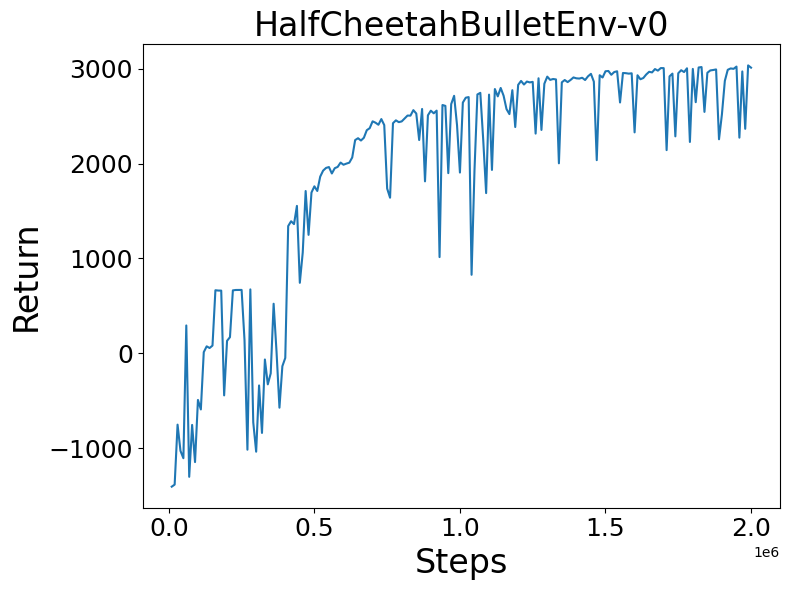

In [ ]:
""" 平均収益のグラフを描画する． """
fig = plt.figure(figsize=(8, 6))
plt.plot(returns['step'], returns['return'])
plt.xlabel('Steps', fontsize=24)
plt.ylabel('Return', fontsize=24)
plt.tick_params(labelsize=18)
plt.title(f'{env.unwrapped.spec.id}', fontsize=24)
plt.tight_layout()

In [ ]:
# 可視化用の環境
monitor_env = gnwrapper.Monitor(make_env(), size=(400, 300),
                                directory='.', video_callable=lambda ep: True)

print('observation space: ', monitor_env.observation_space.shape)
print('action space: ', monitor_env.action_space.shape)

monitor_state = monitor_env.reset()
random = False
done = False
total_reward = 0.
steps = 0
frames = []
actions = []

while not done:
    steps += 1

    if random:
        # ランダム方策から得た行動をとる
        action = monitor_env.action_space.sample()
    else:
        # 学習済みモデルを使う
        action = algo.exploit(monitor_state)

    monitor_state, reward, done, _ = monitor_env.step(action)

    total_reward += reward
    frames.append(monitor_state)
    actions.append(action)


print('total reward: ', total_reward)
print('steps: ', steps)

monitor_env.display()

del monitor_env

observation space:  (26,)
action space:  (6,)
total reward:  3009.349927105362
steps:  1000


'rl-video-episode-0.mp4'

In [ ]:
actions = np.stack(actions)

np.save("drive/MyDrive/Colab Notebooks/MatsuoLab/World Model/actions", actions)